In [ ]:
"""
BUTTERFLY CLASSIFIER (TensorFlow • MobileNetV2)
Full, runnable Colab-style notebook rewritten into clearly named "cells" (sections)
with explicit mapping to the 8 Key Factors for ML/DL Accuracy.

HOW TO USE
- Run top-to-bottom in Google Colab. Each section is a "cell". You can split them into actual notebook cells.
- Places marked (OPTIONAL) can be toggled via flags.

8 KEY FACTORS — EXACT STEP NAMES, WHERE/WHEN IMPLEMENTED, HOW
1) Data Quality & Quantity
   - STEP A1: Kaggle Download & Unzip (when: before anything) — ensures the full dataset is present.
   - STEP A2: Dataset Layout Detection & Verification (when: after unzip) — checks folders/CSV; verifies images.
   - STEP A3: Clean Build of train_df with SHA-1 Dedupe (when: after verification) — removes corrupt/duplicate files.
   - STEP A4: Class Balance Aware Split + Class Weights (when: before dataloader) — stratified split, compute weights.

2) Feature Engineering (for CNNs)
   - STEP B1: Uniform Preprocessing (when: in input pipeline) — decode, normalize to [0,1], resize 224×224.
   - STEP B2: Dimensionality Reduction (implicit) (when: model head) — GlobalAveragePooling2D.

3) Model Selection & Architecture
   - STEP C1: Pretrained MobileNetV2 Backbone (when: build model) — ImageNet weights; fallback to random.
   - STEP C2: Proper Depth + Regularized Head (when: build model) — GAP → Dropout → L2 Dense softmax.

4) Hyperparameter Tuning (baseline knobs)
   - STEP D1: Optimizer & Schedules (when: compile) — AdamW, ReduceLROnPlateau.
   - STEP D2: Label Smoothing (when: compile) — 0.10 smoothing.
   - STEP D3: OOM-Safe Batch Fallback (when: fit) — tries [64, 32, 16].
   - STEP D4: Fine-tune LR Reduction (when: stage 2) — LR × 0.1 for unfrozen layers.

5) Data Augmentation
   - STEP E1: On-the-fly Augment (when: train pipeline) — flip, rotation, zoom, contrast, translation.
   - STEP E2 (OPTIONAL): MixUp (when: after batching train ds) — stronger regularization, toggle via flag.

6) Regularization & Generalization
   - STEP F1: Dropout (when: model head) — 0.25.
   - STEP F2: Weight Decay (when: optimizer) — AdamW wd=1e-4; L2 on Dense.
   - STEP F3: Early Stopping + Best Checkpoint (when: callbacks) — patience=5.

7) Evaluation & Feedback Loop
   - STEP G1: Proper Validation (when: split) — stratified 90/10.
   - STEP G2: Metrics & Artifacts (when: post-train) — classification report, confusion matrix, metrics.json.
   - STEP G3: Hardest Examples (when: post-train) — top-N by cross-entropy for error analysis.
   - STEP G4: Quick Val% Reader (when: anytime post-eval) — prints neatly.

8) Computational Resources
   - STEP H1: Mixed Precision (when: before build) — policy "mixed_float16".
   - STEP H2 (OPTIONAL): XLA (when: early runtime) — can speed up on Colab GPUs.

"""

# ===============================
# CELL 0 — RUNTIME FLAGS & UTILS
# (Touch only if you know why.)
# Affects: All subsequent steps
# Factors: (meta)
# ===============================

from __future__ import annotations
import os, math, json, gc, glob, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Reproducibility
SEED = 42
VAL_FRAC = 0.10
IMG_SIZE = (224, 224)
NUM_CHANNELS = 3
BATCH_CANDIDATES = [64, 32, 16]
BASE_LR = 3e-4
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
AUTOTUNE = tf.data.AUTOTUNE

# Optional toggles
USE_XLA = True           # STEP H2 (OPTIONAL): turn on XLA JIT
USE_MIXUP = False        # STEP E2 (OPTIONAL): MixUp regularization
MIXUP_ALPHA = 0.2

# Set seeds & determinism
try:
    tf.keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

if USE_XLA:
    try:
        tf.config.optimizer.set_jit(True)  # STEP H2
    except Exception:
        pass

print("[conf] SEED=", SEED, "VAL_FRAC=", VAL_FRAC, "IMG_SIZE=", IMG_SIZE)



[conf] SEED= 42 VAL_FRAC= 0.1 IMG_SIZE= (224, 224)


In [ ]:
# ======================================
# CELL 1 — STEP A1: KAGGLE DOWNLOAD & UNZIP
# When: Before anything else
# Factors: 1) Data Quality & Quantity
# ======================================
# NOTE: In Colab, run this cell once per session.
RUN_KAGGLE_DOWNLOAD = True  # Set False if the files already exist in /content/butterfly_data

if RUN_KAGGLE_DOWNLOAD:
    try:
        # Install kaggle
        !pip -q install kaggle
        from google.colab import files
        print("\n[auth] Upload your kaggle.json from https://www.kaggle.com/ -> Account -> API")
        files.upload()  # Choose kaggle.json
        os.makedirs("/root/.kaggle", exist_ok=True)
        !mv kaggle.json /root/.kaggle/kaggle.json
        !chmod 600 /root/.kaggle/kaggle.json
        # Download dataset
        !kaggle datasets download -d phucthaiv02/butterfly-image-classification
        # Unzip to a consistent root
        import zipfile
        with zipfile.ZipFile("butterfly-image-classification.zip", 'r') as z:
            z.extractall("butterfly_data")
        print("[data] Downloaded & extracted to ./butterfly_data")
    except Exception as e:
        print("[warn] Kaggle step skipped/failed:", e)


[auth] Upload your kaggle.json from https://www.kaggle.com/ -> Account -> API


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 53% 120M/226M [00:00<00:00, 1.25GB/s]
100% 226M/226M [00:00<00:00, 789MB/s] 
[data] Downloaded & extracted to ./butterfly_data


In [ ]:

# ======================================================
# CELL 2 — STEP A2: DATASET LAYOUT DETECTION & VERIFICATION
# When: After unzip
# Factors: 1) Data Quality & Quantity
# ======================================================

# Resolve dataset paths (supports multiple layouts)
_candidates = [
    ("/content/butterfly_data/train", "/content/butterfly_data/test"),
    ("/content/train", "/content/test"),
    ("./butterfly_data/train", "./butterfly_data/test"),
    ("./train", "./test"),
]
for _tr, _te in _candidates:
    if os.path.isdir(_tr) and os.path.isdir(_te):
        TRAIN_DIR, TEST_DIR = _tr, _te
        break
else:
    raise FileNotFoundError("train/ and test/ folders not found under expected roots.")

# Optional CSVs
_csv_candidates = [
    "/content/Training_set.csv", "/content/Testing_set.csv",
    os.path.join(os.path.dirname(TRAIN_DIR), "Training_set.csv"),
    os.path.join(os.path.dirname(TEST_DIR),  "Testing_set.csv"),
    os.path.join("/content/butterfly_data", "Training_set.csv"),
    os.path.join("/content/butterfly_data", "Testing_set.csv"),
]
TRAIN_CSV = next((p for p in _csv_candidates if os.path.isfile(p) and p.endswith("Training_set.csv")), None)
TEST_CSV  = next((p for p in _csv_candidates if os.path.isfile(p) and p.endswith("Testing_set.csv")),  None)

print(f"[paths] TRAIN_DIR={TRAIN_DIR}\n[paths] TEST_DIR={TEST_DIR}")
print(f"[csv] TRAIN_CSV={TRAIN_CSV}")
print(f"[csv] TEST_CSV={TEST_CSV}")

# Helpers
_IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp")

def _list_images(d):
    return [p for p in glob.glob(os.path.join(d, "*")) if os.path.isfile(p) and p.lower().endswith(_IMG_EXT)]

def _has_images(d):
    return len(_list_images(d)) > 0

def has_class_subdirs(path):
    if not os.path.isdir(path): return False
    subs = [s for s in os.listdir(path) if os.path.isdir(os.path.join(path, s))]
    return any(_has_images(os.path.join(path, s)) for s in subs)

LAYOUT = None
if has_class_subdirs(TRAIN_DIR):
    class_names = sorted([s for s in os.listdir(TRAIN_DIR)
                          if os.path.isdir(os.path.join(TRAIN_DIR, s)) and _has_images(os.path.join(TRAIN_DIR, s))])
    class_counts = {c: len(_list_images(os.path.join(TRAIN_DIR, c))) for c in class_names}
    LAYOUT = "folders"
    print(f"[ok] Folder layout with {len(class_names)} classes. Sample counts (first 5):", dict(list(class_counts.items())[:5]))
else:
    if not TRAIN_CSV or not os.path.isfile(TRAIN_CSV):
        raise RuntimeError("No class subfolders AND Training_set.csv not found.")
    df = pd.read_csv(TRAIN_CSV)
    fname_cols = ["filename","file","image","image_id","Image","img","image_name"]
    label_cols = ["label","class","species","target","Category","category"]
    fcol = next((c for c in fname_cols if c in df.columns), None)
    lcol = next((c for c in label_cols if c in df.columns), None)
    if fcol is None or lcol is None:
        raise ValueError(f"CSV must have filename & label columns. Found: {list(df.columns)}")
    LAYOUT = "csv"
    print(f"[ok] CSV layout detected. Columns: {fcol} (filename), {lcol} (label)")

# Test dir sanity (leakage guard)
if os.path.isdir(TEST_DIR):
    subs = [s for s in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, s))]
    if subs and has_class_subdirs(TEST_DIR):
        print("[warn] test/ has class subfolders — treat as labeled only if intended.")
    else:
        print("[ok] test/ appears unlabeled (expected).")

print(f"[summary] Layout={LAYOUT}")

[paths] TRAIN_DIR=/content/butterfly_data/train
[paths] TEST_DIR=/content/butterfly_data/test
[csv] TRAIN_CSV=/content/butterfly_data/Training_set.csv
[csv] TEST_CSV=/content/butterfly_data/Testing_set.csv
[ok] CSV layout detected. Columns: filename (filename), label (label)
[ok] test/ appears unlabeled (expected).
[summary] Layout=csv


In [ ]:
# ============================================================
# CELL 3 — STEP A3: CLEAN train_df WITH SHA-1 DEDUPE & VERIFY
# When: After verification
# Factors: 1) Data Quality & Quantity
# ============================================================

assert TRAIN_CSV and os.path.isfile(TRAIN_CSV) if LAYOUT=="csv" else True

# If CSV layout, try to resolve filenames → absolute paths robustly
if LAYOUT == "csv":
    df_csv = pd.read_csv(TRAIN_CSV)
    cols = {c.lower(): c for c in df_csv.columns}
    fcol = cols.get("filename") or cols.get("file") or cols.get("image") or cols.get("img")
    lcol = cols.get("label") or cols.get("class") or cols.get("species")
    if not (fcol and lcol):
        raise ValueError(f"CSV needs filename+label. Found: {list(df_csv.columns)}")
    df_csv = df_csv[[fcol, lcol]].rename(columns={fcol:"filename", lcol:"label"})
    df_csv["filename"] = df_csv["filename"].astype(str).str.strip()
    df_csv["label"]    = df_csv["label"].astype(str).str.strip()

    # Search images recursively across likely roots
    exts = (".jpg",".jpeg",".png",".webp",".bmp",".gif")
    search_roots = list(dict.fromkeys([
        TRAIN_DIR, os.path.dirname(TRAIN_DIR), "/content", "/content/butterfly_data", "/content/_unzipped", "./"
    ]))
    all_paths = []
    for root in search_roots:
        if os.path.isdir(root):
            all_paths += glob.glob(os.path.join(root, "**", "*"), recursive=True)
    img_paths = [p for p in all_paths if p.lower().endswith(exts)]

    # Map by basename (case-insensitive)
    basename_map = {}
    for p in img_paths:
        basename_map[os.path.basename(p).lower()] = p

    df_csv["path"] = df_csv["filename"].apply(lambda s: basename_map.get(os.path.basename(s).lower()))
    missing = df_csv["path"].isna().sum()
    if missing:
        print(f"[warn] {missing} CSV filenames not found on disk. Showing first 10:")
        print(df_csv[df_csv["path"].isna()].head(10))

    # Build clean df with corruption check + dedupe
    good_p, good_l, hashes, bad = [], [], [], []
    for fpath, cls in zip(df_csv["path"].dropna(), df_csv["label"][df_csv["path"].notna()]):
        try:
            raw = tf.io.read_file(fpath)
            _ = tf.io.decode_image(raw, channels=3, expand_animations=False)  # robust for all listed formats
            hashes.append(hashlib.sha1(raw.numpy()).hexdigest())
            good_p.append(fpath); good_l.append(cls)
        except Exception as e:
            bad.append((fpath, str(e)))

    train_df = pd.DataFrame({"path": good_p, "label": good_l, "sha1": hashes})
    before = len(train_df)
    train_df = train_df.drop_duplicates(subset=["sha1"], keep="first").reset_index(drop=True)
    after = len(train_df)

    CLASS_NAMES = sorted(train_df["label"].unique().tolist())
    CLASS2IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
    NUM_CLASSES = len(CLASS_NAMES)

    print(f"[csv] classes={NUM_CLASSES} files={after} dedup_removed={before-after} bad={len(bad)}")
    print("Classes (first 10):", CLASS_NAMES[:10])
    print(train_df.groupby("label").size().head().to_string())

else:  # LAYOUT == folders
    # Build df by walking class subfolders
    paths, labels = [], []
    CLASS_NAMES = sorted([c for c in os.listdir(TRAIN_DIR)
                          if os.path.isdir(os.path.join(TRAIN_DIR, c)) and _has_images(os.path.join(TRAIN_DIR, c))])
    CLASS2IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
    for cls in CLASS_NAMES:
        cdir = os.path.join(TRAIN_DIR, cls)
        for p in _list_images(cdir):
            paths.append(p); labels.append(cls)

    # Corruption check + dedupe
    good_p, good_l, hashes, bad = [], [], [], []
    for pth, cls in zip(paths, labels):
        try:
            raw = tf.io.read_file(pth)
            _ = tf.io.decode_image(raw, channels=3, expand_animations=False)
            hashes.append(hashlib.sha1(raw.numpy()).hexdigest())
            good_p.append(pth); good_l.append(cls)
        except Exception as e:
            bad.append((pth, str(e)))

    train_df = pd.DataFrame({"path": good_p, "label": good_l, "sha1": hashes})
    before = len(train_df)
    train_df = train_df.drop_duplicates(subset=["sha1"], keep="first").reset_index(drop=True)
    after = len(train_df)
    NUM_CLASSES = len(CLASS_NAMES)

    print(f"[folders] classes={NUM_CLASSES} files={after} dedup_removed={before-after} bad={len(bad)}")

assert len(train_df) > 0, "No matched images. Inspect warnings above and ensure the zip was extracted."

[csv] classes=75 files=6495 dedup_removed=4 bad=0
Classes (first 10): ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK']
label
ADONIS                       88
AFRICAN GIANT SWALLOWTAIL    75
AMERICAN SNOOT               74
AN 88                        85
APPOLLO                      90


In [ ]:

# =================================================================
# CELL 4 — STEP A4 & G1: STRATIFIED SPLIT + CLASS WEIGHTS (BALANCE)
# When: Before data pipeline
# Factors: 1) Data Quality & Quantity, 7) Eval (proper validation)
# =================================================================

y = train_df["label"].values
train_idx, val_idx = train_test_split(
    np.arange(len(train_df)), test_size=VAL_FRAC, random_state=SEED, stratify=y
)
train_split = train_df.iloc[train_idx].reset_index(drop=True)
val_split   = train_df.iloc[val_idx].reset_index(drop=True)

class_indices = train_split["label"].map(CLASS2IDX).values
cw = compute_class_weight(class_weight="balanced", classes=np.arange(NUM_CLASSES), y=class_indices)
CLASS_WEIGHTS = {i: float(w) for i, w in enumerate(cw)}
imbalance_ratio = max(CLASS_WEIGHTS.values())/max(1e-9, min(CLASS_WEIGHTS.values()))
print("[balance] class_weights=", CLASS_WEIGHTS)
print("[balance] imbalance_ratio=", round(imbalance_ratio,2))

[balance] class_weights= {0: 0.9864978902953586, 1: 1.146078431372549, 2: 1.16318407960199, 3: 1.0121212121212122, 4: 0.9621399176954732, 5: 0.8659259259259259, 6: 0.8957854406130268, 7: 1.039111111111111, 8: 1.067579908675799, 9: 1.0121212121212122, 10: 1.146078431372549, 11: 1.0121212121212122, 12: 0.8756554307116104, 13: 0.9621399176954732, 14: 1.039111111111111, 15: 0.9168627450980392, 16: 1.0121212121212122, 17: 0.9277777777777778, 18: 0.9991452991452991, 19: 0.9389558232931727, 20: 0.9991452991452991, 21: 0.9621399176954732, 22: 0.9168627450980392, 23: 0.8957854406130268, 24: 1.198974358974359, 25: 0.9168627450980392, 26: 0.9277777777777778, 27: 0.9389558232931727, 28: 0.9168627450980392, 29: 1.053153153153153, 30: 1.1808080808080808, 31: 1.1133333333333333, 32: 0.9168627450980392, 33: 0.9864978902953586, 34: 1.0121212121212122, 35: 1.067579908675799, 36: 0.9168627450980392, 37: 1.067579908675799, 38: 1.067579908675799, 39: 1.1808080808080808, 40: 0.9991452991452991, 41: 1.012121

In [ ]:
# ================================================
# CELL 5 — STEP B1: DATA PIPELINE (+ STEP E1 AUG)
# When: After split
# Factors: 2) Features (preprocess), 5) Augmentation
# ================================================

def decode_resize(path, label_idx, training):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)  # robust for jpg/png/webp/bmp/gif
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return img, tf.one_hot(label_idx, NUM_CLASSES)

AUG = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
    layers.RandomTranslation(0.05, 0.05),
], name="aug")

def make_ds(df: pd.DataFrame, training: bool):
    paths = df["path"].values
    lbls  = df["label"].map(CLASS2IDX).values.astype(np.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, lbls))
    if training:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p,l: decode_resize(p, l, training), num_parallel_calls=AUTOTUNE)
    ds = ds.cache()  # speed-up across epochs (fits for this dataset)
    if training:
        ds = ds.map(lambda x,y: (AUG(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(1)  # we will rebatch right before fit()
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds_1 = make_ds(train_split, training=True)
val_ds_1   = make_ds(val_split,   training=False)

# STEP E2 (OPTIONAL): MixUp utility — applied after we rebatch
try:
    import tensorflow_probability as tfp
    TFP_AVAILABLE = True
except Exception:
    TFP_AVAILABLE = False


def apply_mixup(ds, alpha=0.2):
    if not TFP_AVAILABLE:
        print("[mixup] TFP not available; skipping.")
        return ds
    def _map(batch_x, batch_y):
        bs = tf.shape(batch_x)[0]
        lam = tfp.distributions.Beta(alpha, alpha).sample([bs])
        lam = tf.cast(tf.reshape(lam, [-1,1,1,1]), batch_x.dtype)
        perm = tf.random.shuffle(tf.range(bs))
        x2, y2 = tf.gather(batch_x, perm), tf.gather(batch_y, perm)
        x = lam*batch_x + (1.0-lam)*x2
        y = lam*batch_y + (1.0-lam)*y2
        return x, y
    return ds.map(_map, num_parallel_calls=AUTOTUNE)

In [ ]:
# ============================================
# CELL 6 — STEP H1: MIXED PRECISION (RESOURCES)
# When: Before building the model
# Factors: 8) Computational Resources
# ============================================

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("[mp] policy:", mixed_precision.global_policy())

[mp] policy: <DTypePolicy "mixed_float16">


In [ ]:
# ==================================================
# CELL 7 — STEPS C1 & C2: MODEL BUILD (PRETRAINED)
# When: After pipeline, before compile
# Factors: 3) Model Selection & Architecture; 6) Dropout/L2
# ==================================================

def build_mnv2(num_classes: int):
    inputs = layers.Input(shape=IMG_SIZE + (NUM_CHANNELS,), name="input")
    try:
        base = keras.applications.MobileNetV2(
            include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,), pooling=None
        )
    except Exception as e:
        print("[warn] ImageNet weights unavailable, using random init:", e)
        base = keras.applications.MobileNetV2(
            include_top=False, weights=None, input_shape=IMG_SIZE + (3,), pooling=None
        )
    base.trainable = False  # Stage 1: frozen
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="gap")(x)   # STEP B2 implicit DR
    x = layers.Dropout(0.25, name="drop")(x)           # STEP F1
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32",  # numeric stability under mp
                           kernel_regularizer=keras.regularizers.l2(1e-4), name="pred")(x)  # STEP F2 (L2)
    return keras.Model(inputs, outputs, name="mnv2_224")

model = build_mnv2(NUM_CLASSES)
model.summary(expand_nested=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mnv2_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop (Dropout)                  │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,354,059 (8.98 MB)

 Trainable params: 96,075 (375.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# =================================================================
# CELL 8 — STEPS D1 & D2 & F3: COMPILE + CALLBACKS (TUNING)
# When: After model build
# Factors: 4) HP Tuning (optimizer/LR), 6) Early Stop, 6) Weight Decay
# =================================================================

# Loss with label smoothing (STEP D2)
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.10)

# AdamW (weight decay) + ReduceLROnPlateau (STEP D1, F2)
try:
    OptimW = keras.optimizers.AdamW
except AttributeError:
    OptimW = tf.keras.optimizers.experimental.AdamW

optimizer = OptimW(learning_rate=BASE_LR, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# Callbacks — EarlyStopping, Checkpoint, LR reduce (STEP F3)
ckpt_path = "mnv2_best.keras"
cbs = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, mode="max"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    keras.callbacks.CSVLogger("training_log.csv")
]

In [ ]:
# =======================================================
# CELL 9 — STAGE 1 TRAIN (FROZEN) + OOM-SAFE BATCH (D3)
# When: First training stage
# Factors: 4) HP (batch/epochs), 6) Early Stop
# =======================================================

history1 = None

def rebatch(ds, bs):
    return ds.unbatch().batch(bs).prefetch(AUTOTUNE)

for bs in BATCH_CANDIDATES:
    try:
        print(f"[fit] stage1 with batch_size={bs}")
        train_ds = rebatch(train_ds_1, bs)
        val_ds   = rebatch(val_ds_1, bs)
        if USE_MIXUP and bs > 1:
            train_ds = apply_mixup(train_ds, alpha=MIXUP_ALPHA)  # STEP E2 (OPTIONAL)
        history1 = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS_STAGE1,
            class_weight=CLASS_WEIGHTS if imbalance_ratio > 1.5 else None,
            callbacks=cbs,
            verbose=1
        )
        break
    except tf.errors.ResourceExhaustedError as e:
        print("[oom] lowering batch size:", e)
        continue

assert history1 is not None, "Training failed for all batch sizes in Stage 1."

[fit] stage1 with batch_size=64
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8798 - loss: 1.3832 - val_accuracy: 0.8200 - val_loss: 1.5751 - learning_rate: 3.0000e-05
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8694 - loss: 1.3935 - val_accuracy: 0.8246 - val_loss: 1.5726 - learning_rate: 3.0000e-05
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8787 - loss: 1.3907 - val_accuracy: 0.8262 - val_loss: 1.5702 - learning_rate: 3.0000e-05
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8680 - loss: 1.3966 - val_accuracy: 0.8231 - val_loss: 1.5667 - learning_rate: 3.0000e-05
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8681 - loss: 1.3869 - val_accuracy: 0.8262 - val_loss: 1.5636 - learning_rate: 3.0000e-05
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8723 - loss: 1.3785 - val_accuracy: 0.8262 - val_loss: 1.5616 - learning_rate: 3.0000e-05
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# ======================================================
# CELL 10 — STAGE 2 FINETUNE (UNFREEZE + LR × 0.1) (D4)
# When: After Stage 1 converges
# Factors: 4) LR tuning for fine-tune, 3) Transfer learning depth
# ======================================================

# Unfreeze top fraction of base
UNFREEZE_TOP_FRACTION = 0.4
base = model.layers[1] if len(model.layers) > 1 else None
if base and hasattr(base, "layers"):
    total = len(base.layers)
    cut = int(total * (1 - UNFREEZE_TOP_FRACTION))
    for i, layer in enumerate(base.layers):
        layer.trainable = (i >= cut)
    print(f"[finetune] unfreezing last ~{UNFREEZE_TOP_FRACTION*100:.0f}% of base ({total-cut} layers).")

# Lower LR by 10× (STEP D4)
ft_lr = float(BASE_LR) * 0.1
opt = model.optimizer
lr_attr = getattr(opt, "learning_rate", None)
if isinstance(lr_attr, tf.Variable):
    lr_attr.assign(ft_lr)
elif isinstance(lr_attr, (tf.Tensor,)):
    opt.learning_rate = tf.Variable(ft_lr, dtype=tf.float32)
elif callable(lr_attr):
    print("[ft] LR schedule detected; leaving schedule intact.")
else:
    try:
        opt.learning_rate = ft_lr
    except Exception as e:
        print("[ft] direct set failed, recompiling optimizer:", e)
        wd = getattr(opt, "weight_decay", 0.0)
        model.compile(optimizer=OptimW(learning_rate=ft_lr, weight_decay=wd), loss=model.loss, metrics=model.metrics)

print("[ft] learning_rate now:", float(model.optimizer.learning_rate.numpy() if hasattr(model.optimizer.learning_rate, 'numpy') else ft_lr))

history2 = None
for bs in BATCH_CANDIDATES:
    try:
        print(f"[fit] stage2 with batch_size={bs}")
        train_ds = rebatch(train_ds_1, bs)
        val_ds   = rebatch(val_ds_1, bs)
        if USE_MIXUP and bs > 1:
            train_ds = apply_mixup(train_ds, alpha=MIXUP_ALPHA)
        history2 = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS_STAGE2,
            class_weight=CLASS_WEIGHTS if imbalance_ratio > 1.5 else None,
            callbacks=cbs,
            verbose=1
        )
        break
    except tf.errors.ResourceExhaustedError as e:
        print("[oom] lowering batch size:", e)
        continue

# Load best weights
model.load_weights("mnv2_best.keras")

[finetune] unfreezing last ~40% of base (62 layers).
[ft] learning_rate now: 2.9999999242136255e-05
[fit] stage2 with batch_size=64
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8713 - loss: 1.3722 - val_accuracy: 0.8323 - val_loss: 1.5511 - learning_rate: 3.0000e-05
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8857 - loss: 1.3619 - val_accuracy: 0.8323 - val_loss: 1.5492 - learning_rate: 3.0000e-05
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8887 - loss: 1.3563 - val_accuracy: 0.8323 - val_loss: 1.5480 - learning_rate: 3.0000e-05
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8866 - loss: 1.3612 - val_accuracy: 0.8338 - val_loss: 1.5444 - learning_rate: 3.0000e-05
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8787 - loss: 1.3585 - val_accuracy: 0.8354 - val_loss: 1.5417 - learning_rate: 3.0000e-05
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8722 - loss: 1.3655 - val_ac

In [ ]:
# ==========================================================
# CELL 11 — (OPTIONAL) TINY OVERFIT SANITY CHECK (DEVELOPER)
# When: After training; quick pipeline correctness smoke test
# Factors: 7) Feedback loop (sanity)
# ==========================================================

tiny_n = min(32, len(train_split))
tiny_df = train_split.sample(n=tiny_n, random_state=SEED).reset_index(drop=True)
tiny_ds = tf.data.Dataset.from_tensor_slices((
    tiny_df["path"].values,
    tiny_df["label"].map(CLASS2IDX).values.astype(np.int32)
))
tiny_ds = tiny_ds.map(lambda p,l: decode_resize(p,l,True), num_parallel_calls=AUTOTUNE)
tiny_ds = tiny_ds.map(lambda x,y: (AUG(x, training=True), y), num_parallel_calls=AUTOTUNE)
tiny_ds = tiny_ds.batch(16).prefetch(AUTOTUNE)

tmp = build_mnv2(NUM_CLASSES)
tmp.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
h = tmp.fit(tiny_ds, epochs=10, verbose=0)
print("[sanity] tiny overfit best acc:", f"{max(h.history['accuracy']):.3f}")
del tmp; gc.collect()

[sanity] tiny overfit best acc: 0.938


230

                           precision    recall  f1-score   support

                   ADONIS     0.8889    0.8889    0.8889         9
AFRICAN GIANT SWALLOWTAIL     1.0000    1.0000    1.0000         7
           AMERICAN SNOOT     0.8750    1.0000    0.9333         7
                    AN 88     1.0000    1.0000    1.0000         8
                  APPOLLO     0.7500    0.6667    0.7059         9
                    ATALA     1.0000    1.0000    1.0000        10
 BANDED ORANGE HELICONIAN     0.8750    0.7000    0.7778        10
           BANDED PEACOCK     1.0000    0.8750    0.9333         8
            BECKERS WHITE     0.8889    1.0000    0.9412         8
         BLACK HAIRSTREAK     0.7778    0.8750    0.8235         8
              BLUE MORPHO     1.0000    1.0000    1.0000         7
        BLUE SPOTTED CROW     1.0000    1.0000    1.0000         9
           BROWN SIPROETA     1.0000    0.6000    0.7500        10
            CABBAGE WHITE     0.7500    1.0000    0.8571     

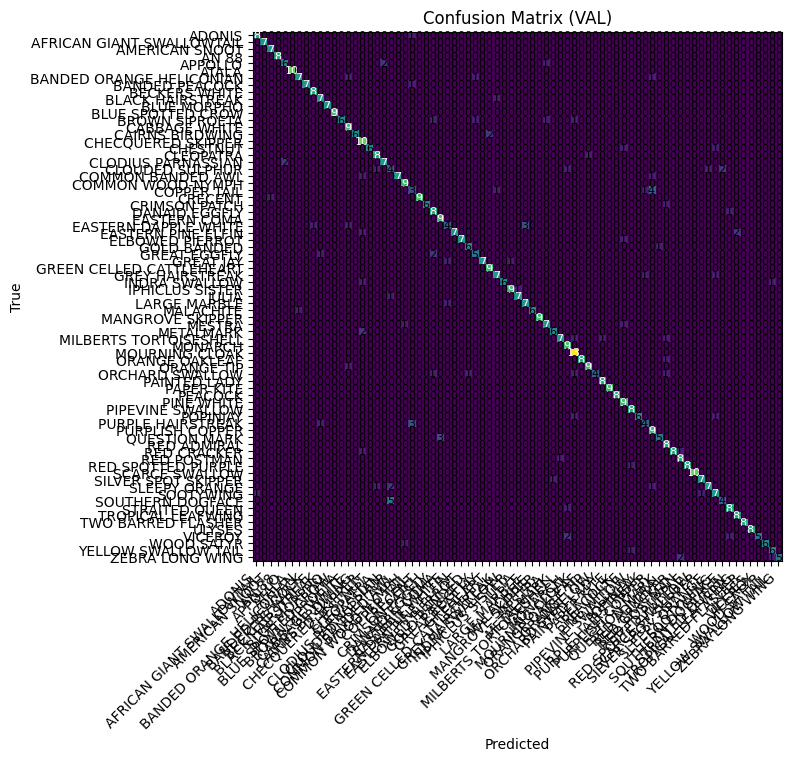

Saved: results/metrics.json results/confusion_matrix.png
Saved: results/hardest_examples_topN.json


In [ ]:
# ======================================================
# CELL 12 — STEPS G2 & G3: EVAL, REPORTS, ARTIFACTS
# When: After Stage 2 (and weights reloaded)
# Factors: 7) Evaluation & Feedback Loop
# ======================================================

import matplotlib.pyplot as plt
os.makedirs("results", exist_ok=True)

val_paths = val_split["path"].values
val_y_idx = val_split["label"].map(CLASS2IDX).values.astype(int)

val_ds_eval = tf.data.Dataset.from_tensor_slices((val_paths, val_y_idx))
val_ds_eval = val_ds_eval.map(lambda p,l: decode_resize(p,l,False), num_parallel_calls=AUTOTUNE)
val_ds_eval = val_ds_eval.batch(64).prefetch(AUTOTUNE)

probs = model.predict(val_ds_eval, verbose=0)
pred_idx = probs.argmax(axis=1)

# Metrics report
report = classification_report(val_y_idx, pred_idx, target_names=CLASS_NAMES, output_dict=True, digits=4)
overall_acc = float(accuracy_score(val_y_idx, pred_idx))
print(classification_report(val_y_idx, pred_idx, target_names=CLASS_NAMES, digits=4))
print("Overall accuracy:", f"{overall_acc:.4f}")

# Save metrics.json
metrics_payload = {
    "overall_accuracy": overall_acc,
    "per_class": {k: v for k, v in report.items() if k in CLASS_NAMES},
    "macro_avg": report.get("macro avg", {}),
    "weighted_avg": report.get("weighted avg", {}),
    "num_samples": int(len(val_y_idx))
}
with open("results/metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

# Confusion matrix figure
cm = confusion_matrix(val_y_idx, pred_idx, labels=np.arange(len(CLASS_NAMES)))
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix (VAL)")
ax.set_xticks(np.arange(len(CLASS_NAMES))); ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticks(np.arange(len(CLASS_NAMES))); ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8,
                color="white" if cm[i,j] > cm.max()/2 else "black")
fig.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=150)
plt.show()
print("Saved:", "results/metrics.json", "results/confusion_matrix.png")

# Hardest examples by cross-entropy
ce_none = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.0,
                                                  reduction=tf.keras.losses.Reduction.NONE)
y_true_oh = tf.one_hot(val_y_idx, depth=len(CLASS_NAMES)).numpy()
sample_losses = ce_none(y_true_oh, probs).numpy()
true_conf = probs[np.arange(len(probs)), val_y_idx]
pred_conf = probs[np.arange(len(probs)), pred_idx]
order = np.lexsort((true_conf, -sample_losses))
TOP_N = int(min(20, len(order)))

hardest = []
for r in range(TOP_N):
    i = order[r]
    hardest.append({
        "rank": int(r+1),
        "loss": float(sample_losses[i]),
        "true_conf": float(true_conf[i]),
        "pred_conf": float(pred_conf[i]),
        "true_label": CLASS_NAMES[val_y_idx[i]],
        "pred_label": CLASS_NAMES[pred_idx[i]],
        "path": str(val_paths[i])
    })

with open("results/hardest_examples_topN.json", "w") as f:
    json.dump({"topN": TOP_N, "items": hardest}, f, indent=2)
print("Saved:", "results/hardest_examples_topN.json")


In [ ]:
# =====================================================
# CELL 13 — TEST INFERENCE (UNLABELED) + CSV EXPORT
# When: After evaluation (optional)
# Factors: (serving utility)
# =====================================================

def build_infer_ds(test_dir: str):
    files = sorted([os.path.join(test_dir, f) for f in tf.io.gfile.listdir(test_dir)])
    ds = tf.data.Dataset.from_tensor_slices(files)
    def _load(p):
        x = tf.io.read_file(p)
        x = tf.io.decode_image(x, channels=3, expand_animations=False)
        x = tf.image.convert_image_dtype(x, tf.float32)
        x = tf.image.resize(x, IMG_SIZE, antialias=True)
        return x, p
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(64).prefetch(AUTOTUNE)
    return ds

infer_ds = build_infer_ds(TEST_DIR)
probs_test = model.predict(infer_ds, verbose=0)
preds_test = probs_test.argmax(axis=1)
idx2cls = {v:k for k,v in CLASS2IDX.items()}
labels_test = [idx2cls[i] for i in preds_test]

os.makedirs("results", exist_ok=True)
pd.DataFrame({"file": sorted([os.path.join(TEST_DIR, f) for f in tf.io.gfile.listdir(TEST_DIR)]),
              "pred": labels_test}).to_csv("results/test_predictions.csv", index=False)
print("Saved: results/test_predictions.csv")

Saved: results/test_predictions.csv


In [ ]:
# ======================================================
# CELL 14 — STEP G4: QUICK VALIDATION ACCURACY PRINTER
# When: Anytime after metrics.json exists
# Factors: 7) Feedback Loop (quick check)
# ======================================================

def pct(x):
    try:
        return f"{round(float(x)*100, 2):.2f}%"
    except Exception:
        return "n/a"

if os.path.isfile("results/metrics.json"):
    with open("results/metrics.json") as f:
        m = json.load(f)
    print("val_accuracy:", pct(m.get("overall_accuracy", 0.0)))
else:
    val_ds_tmp = tf.data.Dataset.from_tensor_slices((val_split["path"].values, val_split["label"].map(CLASS2IDX).values))
    val_ds_tmp = val_ds_tmp.map(lambda p,l: decode_resize(p,l,False), num_parallel_calls=AUTOTUNE).batch(64).prefetch(AUTOTUNE)
    _, acc = model.evaluate(val_ds_tmp, verbose=0)
    print("val_accuracy:", pct(acc))


val_accuracy: 83.69%
